## Analysis of Diurnal Warm Layer Events from Falkor 2019 
### And their relationship to surfactant concentration

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import dask.array as da
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import colorcet as cc
%matplotlib inline

import glob
from tqdm import tqdm

import matlab.engine

In [18]:
coare_outputs = xr.open_dataset('../../Data/Level 1/Shipboard COARE Inputs/fk_shipboard_coare_outputs_1.cdf').to_dataframe()
coare_outputs.head()

,ustar,tau,sensible_flux,latent_flux,buoyancy_flux,hsbb,hlwebb,tsr,qsr,zot,...,Cen_10,RF,Qs,Evap,T10,Q10,RH10,dt_warmlayer,warmlayerthickness,dsea
index,,,,,,,,,,,,,,,,,,,,,
2019-11-21 05:58:53,0.430691,0.214910,50.371460,208.043883,65.962089,63.406248,221.006027,-0.099883,-0.170263,0.000013,...,1.126042,0.0,0.023536,0.326845,24.628681,17.737759,91.309083,0.0,19.0,0.0
2019-11-21 05:58:54,0.448193,0.232813,51.892295,214.254201,67.948349,65.316209,227.604411,-0.098870,-0.168481,0.000012,...,1.129257,0.0,0.023536,0.336604,24.630026,17.738249,91.313275,0.0,19.0,0.0
2019-11-21 05:58:55,0.446724,0.231281,51.803718,213.126565,67.775296,65.157005,226.447496,-0.099028,-0.168148,0.000012,...,1.128984,0.0,0.023539,0.334893,24.629973,17.757205,91.410105,0.0,19.0,0.0
2019-11-21 05:58:56,0.490004,0.278417,55.488365,228.998382,72.649390,69.836107,243.270868,-0.096701,-0.164711,0.000009,...,1.137244,0.0,0.023541,0.359774,24.632858,17.743019,91.322103,0.0,19.0,0.0
2019-11-21 05:58:57,0.494566,0.283639,55.883802,230.616639,73.166109,70.332944,244.990457,-0.096492,-0.164345,0.000009,...,1.138137,0.0,0.023541,0.362317,24.633143,17.743496,91.322978,0.0,19.0,0.0


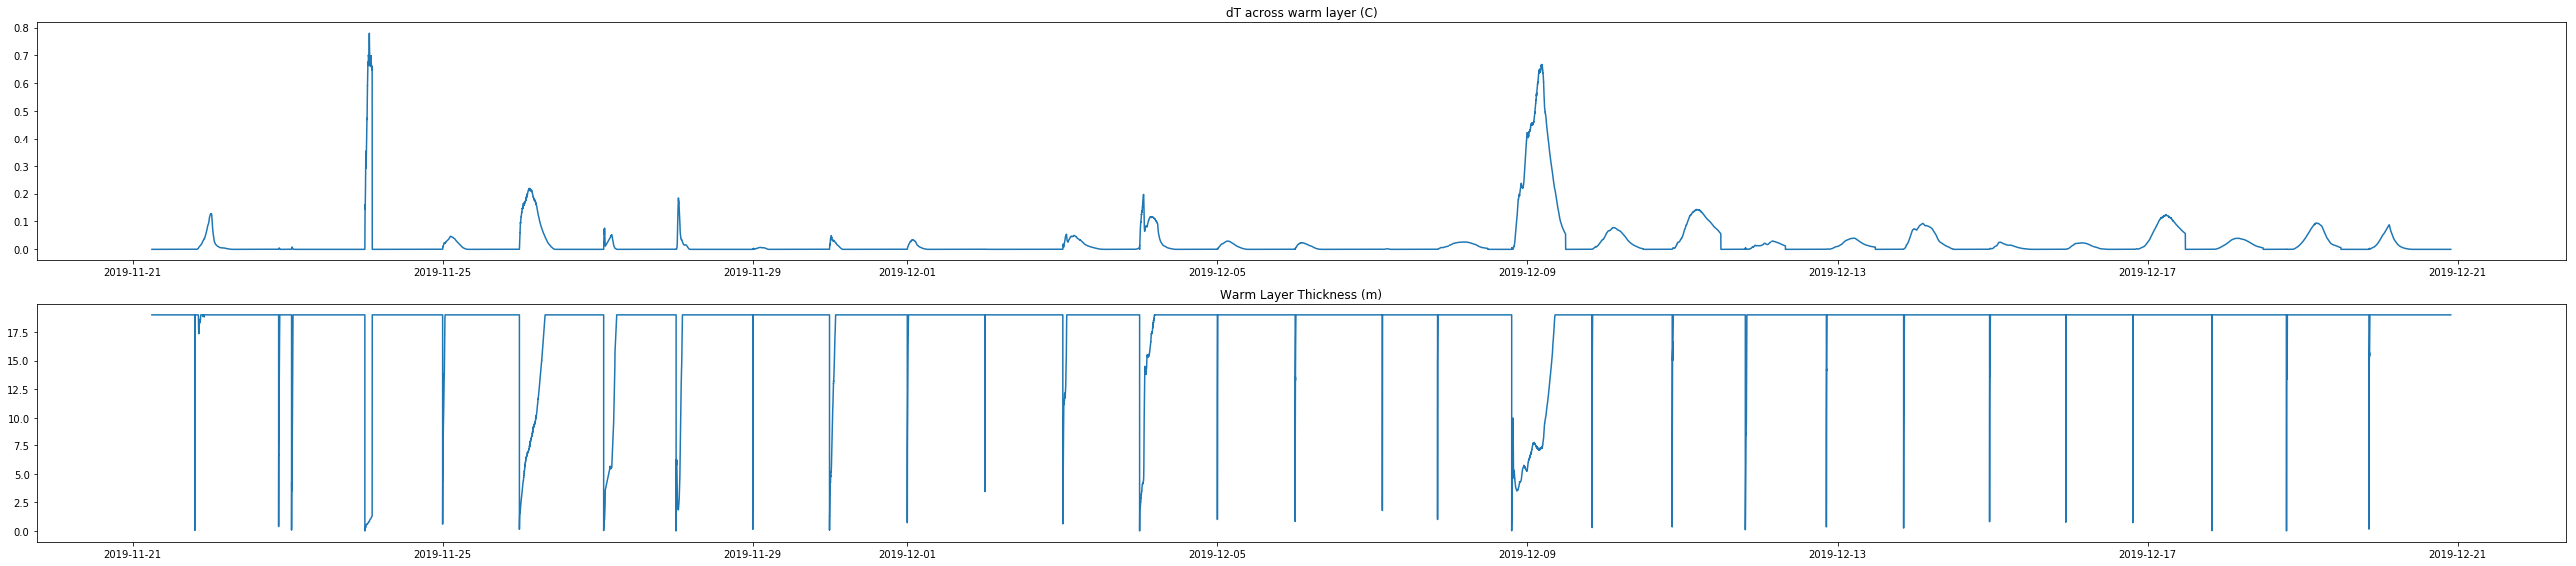

In [21]:
fig,axx = plt.subplots(nrows=2,figsize=(36,8),facecolor='w')
axx[0].plot(coare_outputs.dt_warmlayer)
axx[0].set_title('dT across warm layer (C)')
axx[1].plot(coare_outputs.warmlayerthickness)
axx[1].set_title('Warm Layer Thickness (m)')
plt.tight_layout()

# Appendix 1: Importing Falkor Shipboard Data

In [50]:
def valid_float(y):
    try:
        return float(y)
    except ValueError:
        return np.nan
    except TypeError:
        return np.nan

data_folder = '../../Data/Level 0/Shipboard COARE Inputs/'

#create list of all text files in data_folder
files = glob.glob(data_folder + '\*.csv')
data_list = []

for file in tqdm(files):
    #read in file
    data = pd.read_csv(file, header=None, skiprows=1,
                       names = ['Date','Time','Lat','Lon','SOG','COG','Heading','Pitch','Roll','WindSpd_FM','WindDir_FM','AirTemp_FM','Humidity_FM','Pressure_FM','WindSpd_SMM','WindDir_SMM','AirTemp_SMM','Humidity_SMM','Pressure_SMM','SeaTemp','SeaSal','SW','LW'],
                       parse_dates={'DateTime':[0,1]}, dayfirst=True, index_col=0, error_bad_lines=False, warn_bad_lines=True,
                       converters={'AirTemp_SMM':valid_float, 'Humidity_SMM':valid_float, 'Pressure_SMM':valid_float, 'SW':valid_float, 'SeaSal':valid_float, 'SeaTemp':valid_float})
    
    #lat and lon are in degrees-decimal minutes, ie 4124.89N = 41 degrees, 24.89'N
    #only way to deal with this kind of parsing is one entry at a time...
    LonDDs = []
    LatDDs = []

    for idx in np.arange(0,len(data)):
        #---------LONGITUDE--------------
        lonStr = data.Lon[idx]
        EW = lonStr[-1]          
        lonDegrees = float(lonStr[0:-6])
        lonDecimalMins = float(lonStr[-6:-1])
        lonDecimalDegrees = lonDegrees + lonDecimalMins/60
        if EW == 'W':
            lonDecimalDegrees = lonDecimalDegrees * -1
        LonDDs.append(lonDecimalDegrees)

        #---------LATITUDE--------------
        latStr = data.Lat[idx]
        NS = latStr[-1]          #is this east or west?
        latDegrees = float(latStr[0:-6])
        latDecimalMins = float(latStr[-6:-1])
        latDecimalDegrees = latDegrees + latDecimalMins/60
        if NS == 'S':
            latDecimalDegrees = latDecimalDegrees * -1
        LatDDs.append(latDecimalDegrees)

    data['LatDD'] = LatDDs
    data['LonDD'] = LonDDs
    
    data_list.append(data)
    
fk_pd = pd.concat(data_list, axis=0, sort=True)
fk_pd = fk_pd.sort_index()
fk_xr = xr.Dataset.from_dataframe(fk_pd)
fk_xr = fk_xr.drop(['Date','Time'])
fk_xr.to_netcdf('../../Data/Level 1/Shipboard COARE Inputs/fk_shipboard.cdf')

100%|██████████████████████████████████████████████████████████████████████████████| 1418/1418 [06:50<00:00,  3.41it/s]


# Appendix 2: Run COARE on Falkor Shipboard Data
(This takes several hours to run if you don't downsample the timeseries)

In [22]:
fk = xr.open_dataset('../../Data/Level 1/Shipboard COARE Inputs/fk_shipboard.cdf').to_dataframe()
fk = fk.resample('30min').mean()

eng = matlab.engine.start_matlab()

#Warm Skin COARE
zi_default = 600.0
height = 16.0 #height of metpak above waterline (m) - must be a float
bulkdepth = 5.0 #location of intake valve below waterline (m)

yday = matlab.double((fk.index.dayofyear + (fk.index.hour/(24.0)) + (fk.index.minute/(24.0*60)) + (fk.index.second/(24.0*60*60))).to_list())
Ur = matlab.double(list(fk.WindSpd_FM)) #wind speed (m/s) relative to water at height zu
zu = matlab.double((np.zeros(len(fk))+height).tolist()) #height (m) of wind measurement
Tair = matlab.double(list(fk.AirTemp_FM)) # air temp (degC)at height zt
zt = zu #height (m) of air temperature measurement
RH = matlab.double(list(fk.Humidity_FM)) #relative humidity (%) at height zq
zq = zu #height (m) of air humidity measurement
Pair = matlab.double(list(fk.Pressure_FM)) #air pressure (mb)
Tsea = matlab.double(list(fk.SeaTemp)) #bulk surface sea temp (degC) at ts_depth
ts_depth = matlab.double((np.zeros(len(fk))+bulkdepth).tolist()) #depth (m) of water temperature measurement
Solar = matlab.double(list(fk.SW)) #downward solar flux (w/m^2) defined positive down
IR = matlab.double(list(fk.LW)) #downward IR flux (w/m^2) defined positive down
Lat = matlab.double(list(fk.LatDD)) #latitude (deg N=+)
Lon = matlab.double(list(fk.LonDD)) #longitude (deg E=+)
zi = matlab.double((np.zeros(len(fk))+zi_default).tolist()) #inversion height (m)
Rainrate = matlab.double((np.zeros(len(fk))).tolist()) #rain rate (mm/hr)

coare_out_warmlayer = eng.coare35vnWarm(yday,Ur,height,Tair,height,RH,height,Pair,Tsea,Solar,IR,Lat,Lon,zi_default,Rainrate,bulkdepth)
coare_warmlayer = pd.DataFrame(index=fk.index,data=np.asarray(coare_out_warmlayer),columns=['ustar', 'tau', 'sensible_flux', 'latent_flux', 'buoyancy_flux', 'hsbb', 'hlwebb', 'tsr', 'qsr', 'zot', 'zoq', 'Cd', 'Ch', 'Ce', 'L', 'zet', 'dter', 'dqer', 'tkt', 'Urf', 'Trf', 'Qrf', 'RHrf', 'UrfN', 'Rnl', 'Le', 'rhoa', 'UN', 'U10', 'U10N', 'Cdn_10', 'Chn_10', 'Cen_10', 'RF', 'Qs', 'Evap', 'T10', 'Q10', 'RH10','dt_warmlayer','warmlayerthickness','dsea'])
coare_xr = xr.Dataset.from_dataframe(coare_warmlayer)
coare_xr.to_netcdf('../../Data/Level 1/Shipboard COARE Inputs/fk_shipboard_coare_outputs_30min_v1.cdf')

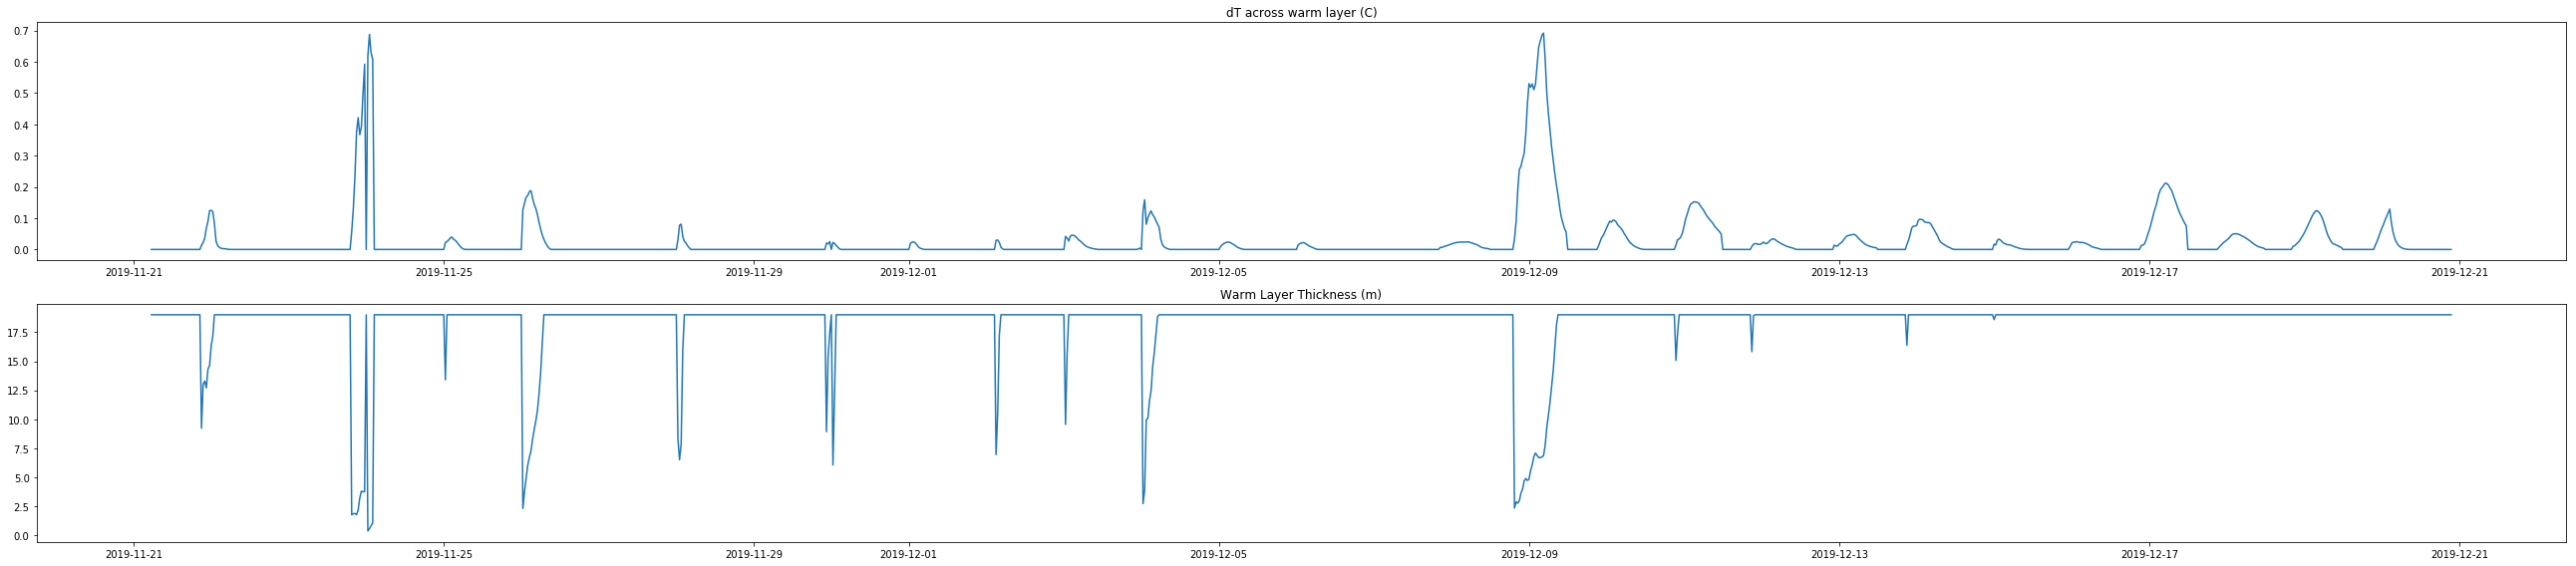

In [25]:
fig,axx = plt.subplots(nrows=2,figsize=(36,8),facecolor='w')
axx[0].plot(coare_warmlayer.dt_warmlayer)
axx[0].set_title('dT across warm layer (C)')
axx[1].plot(coare_warmlayer.warmlayerthickness)
axx[1].set_title('Warm Layer Thickness (m)')
plt.tight_layout()